# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4158.619204,0.9999,-131.886217,1973.67,1841.783783
OMUSDT,526.319895,1803.644751,0.4337,0.000000,1277.32,1277.320000
BTCUSDT,601.021649,909.564656,0.2187,3.537078,308.54,312.077078
JASMYUSDT,387.458505,581.437387,0.1398,0.000000,193.98,193.980000
SOLUSDT,281.200518,394.434615,0.0948,0.000000,113.23,113.230000
ETHUSDT,250.747339,269.968706,0.0649,0.000000,19.22,19.220000
TRXUSDT,76.868953,138.626913,0.0333,-10.723889,61.76,51.036111
BBUSDT,60.176053,59.719456,0.0144,-39.733101,-0.46,-40.193101
BNBUSDT,1.142121,1.222714,0.0003,-10.606040,0.08,-10.526040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [18]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [19]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [20]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [21]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [23]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [24]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [25]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [26]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_2332\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [27]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-10    169.223224
2024-12-11    263.766653
2024-12-12   -134.094487
2024-12-13     14.587632
2024-12-14    -66.766165
Name: Total, Length: 83, dtype: float64

In [28]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-10    1725.847669
2024-12-11    1989.614322
2024-12-12    1855.519835
2024-12-13    1870.107467
2024-12-14    1803.341302
Name: Total, Length: 83, dtype: float64

In [29]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [30]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [31]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [32]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_2332\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [33]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [34]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [35]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

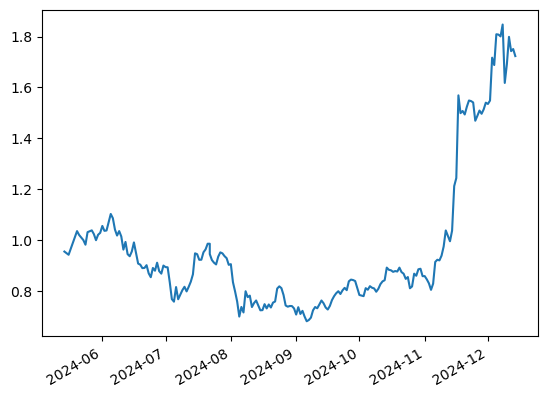

In [36]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [38]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [41]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [42]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'ENSUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [43]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [46]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3795
BNBUSDT,0.1686
PEPEUSDT,0.1284
SUIUSDT,0.0957
TRXUSDT,0.0807
XRPUSDT,0.0775
JASMYUSDT,0.0349
XLMUSDT,0.0347
ADAUSDT,0.0000
ALGOUSDT,0.0000


In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.360373
BTCUSDT,0.300000
PEPEUSDT,0.092140
SUIUSDT,0.074475
TRXUSDT,0.071925
XRPUSDT,0.027651
JASMYUSDT,0.025797
BNBUSDT,0.024193
XLMUSDT,0.023446


### Current results

In [49]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [50]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.459656
OMUSDT,0.322180
TRXUSDT,0.196992
PEPEUSDT,0.021172


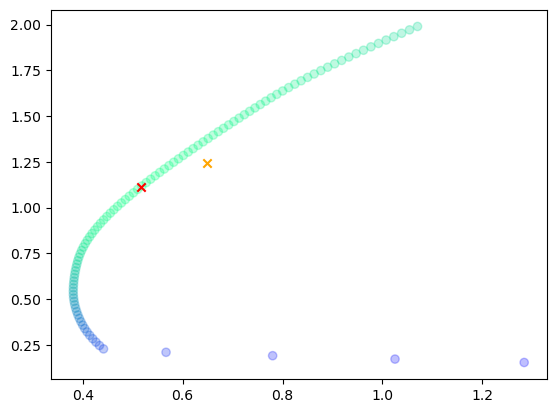

In [51]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [53]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1803.644751,0.433712,0.322180,0.111532
BTCUSDT,909.564656,0.218718,0.459656,-0.240938
JASMYUSDT,581.437387,0.139815,0.000000,0.000000
SOLUSDT,394.434615,0.094848,0.000000,0.000000
ETHUSDT,269.968706,0.064918,0.000000,0.000000
TRXUSDT,138.626913,0.033335,0.196992,-0.163657
BBUSDT,59.719456,0.014360,0.000000,0.000000
BNBUSDT,1.222714,0.000294,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.021172,-0.021172


In [54]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1803.644751,0.433712,0.360373,0.073339
BTCUSDT,909.564656,0.218718,0.300000,-0.081282
JASMYUSDT,581.437387,0.139815,0.025797,0.114018
SOLUSDT,394.434615,0.094848,0.000000,0.000000
ETHUSDT,269.968706,0.064918,0.000000,0.000000
TRXUSDT,138.626913,0.033335,0.071925,-0.038590
BBUSDT,59.719456,0.014360,0.000000,0.000000
BNBUSDT,1.222714,0.000294,0.024193,-0.023899
PEPEUSDT,0.000006,0.000000,0.092140,-0.092140
SUIUSDT,0.000000,0.000000,0.074475,0.000000


# Risk Reward Analysis

In [56]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [57]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

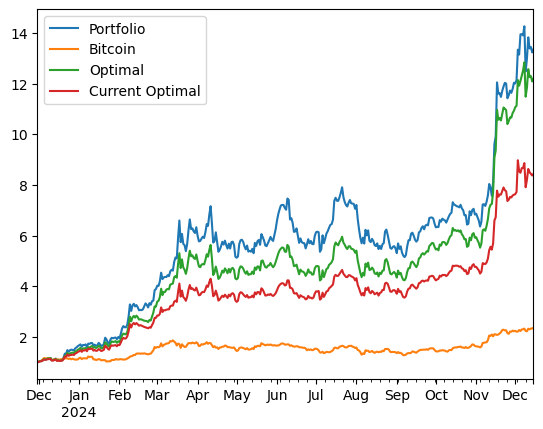

In [58]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [59]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

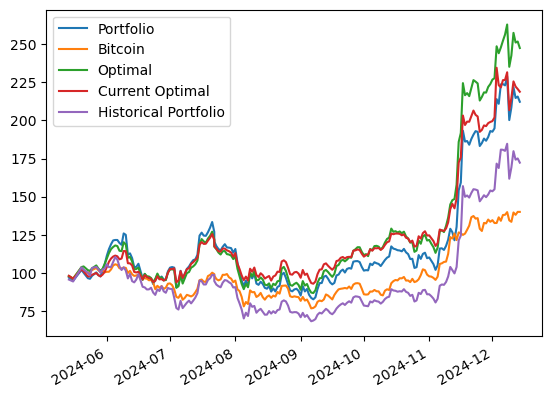

In [60]:
((1+current_perf).cumprod()*100).plot()

In [61]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-05,223.670451,134.162033,247.875080,221.706029,180.882889
2024-12-06,223.855342,137.975577,252.296832,226.439059,180.754476
2024-12-07,223.025743,138.101611,256.395743,226.585441,180.041463
2024-12-08,228.811289,139.857753,262.938498,231.601058,184.701345
2024-12-09,200.254544,134.452552,235.206691,206.743277,161.779517
2024-12-10,208.556243,133.504547,242.633461,214.693050,169.133901
2024-12-11,221.820701,139.625877,257.468279,225.624367,179.858235
2024-12-12,214.754564,138.069846,251.118392,222.238713,174.270669
2024-12-13,215.690667,140.016510,251.778416,220.628571,175.078776
2024-12-14,212.249299,140.010643,247.528663,218.845821,172.317363


## Volatilities

In [63]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.630501
 dtype: float64,
 0.6313019894495598)

In [64]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.648837
 dtype: float64,
 0.6488367321495152)

In [65]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.715190
Bitcoin            0.433981
Optimal            0.631302
Current Optimal    0.562258
dtype: float64

In [66]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.46510522571341767

## Risk Contribution

In [68]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.040072,0.024193,0.003098,0.008842,0.000337,0.008505
BTCUSDT,0.409017,0.300000,0.034184,0.137861,0.042531,0.095330
JASMYUSDT,0.070983,0.025797,0.004666,0.019276,0.002116,0.017161
OMUSDT,18.298676,0.360373,0.899620,0.640842,0.533618,0.107224
PEPEUSDT,0.544873,0.092140,0.030713,0.097233,0.034215,0.063018
SUIUSDT,0.217314,0.074475,0.014068,0.050852,0.012803,0.038050
TRXUSDT,0.074598,0.071925,0.007064,0.022890,0.006200,0.016690
XLMUSDT,0.033249,0.023446,0.002733,0.009778,0.000823,0.008956
XRPUSDT,0.052248,0.027651,0.003852,0.012424,0.000841,0.011583


In [69]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.809299,0.322180,0.513990,0.575385,0.445674,0.129712
BTCUSDT,0.239054,0.459656,0.317399,0.235913,0.133662,0.102251
TRXUSDT,0.143189,0.196992,0.154532,0.169308,0.113012,0.056296
PEPEUSDT,0.009822,0.021172,0.014079,0.019394,0.002030,0.017365


In [70]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.102180,0.438776,0.657257,0.649466,0.523929,0.125537
BTCUSDT,0.116751,0.224490,0.145548,0.089611,0.020207,0.069403
JASMYUSDT,0.074282,0.142857,0.092615,0.146192,0.057944,0.088248
SOLUSDT,0.023336,0.091837,0.049124,0.063761,0.008236,0.055524
ETHUSDT,0.010094,0.061224,0.030419,0.028294,0.002645,0.025649
TRXUSDT,0.022251,0.030612,0.022548,0.012039,0.001730,0.010310
BBUSDT,-0.004368,0.010204,0.002489,0.010638,0.000408,0.010230


# Value At Risk

## Historical

### Optimal Weights

In [74]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05110815160264966, -0.0740489843413088)

### Current Weights

In [76]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04838910956430273, -0.0747847420324609)

In [77]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [78]:
var=historical_var.iloc[row]
var

OMUSDT      -0.017073
BTCUSDT     -0.011503
JASMYUSDT   -0.011602
SOLUSDT     -0.007001
ETHUSDT      0.000963
TRXUSDT     -0.001908
BBUSDT      -0.000127
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048251
Name: 2024-11-25 00:00:00, dtype: float64

In [79]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.041541
BTCUSDT     -0.007745
JASMYUSDT   -0.012724
SOLUSDT     -0.006244
ETHUSDT     -0.002478
TRXUSDT     -0.000948
BBUSDT      -0.000893
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072574
dtype: float64

## Parametric

### Optimal Weights

In [82]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06541301158988874, -0.08384139516217766)

### Current Weights

In [84]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06722989217418404, -0.08617013373158387)

## Multivariate

### Optimal Weights

In [87]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05817266760964207, -0.07427510164899706)

### Current Weights

In [89]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06254143364968608, -0.08080532511420394)

In [90]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.042027
BTCUSDT     -0.005927
JASMYUSDT   -0.007074
SOLUSDT     -0.004105
ETHUSDT     -0.001856
TRXUSDT     -0.000405
BBUSDT      -0.000760
Portfolio   -0.062154
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [94]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05813766264584293, -0.07511595433489132)

### Current Weights

In [96]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06351496560001232, -0.0807016764508136)

In [97]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.040613
BTCUSDT     -0.005921
JASMYUSDT   -0.007976
SOLUSDT     -0.004417
ETHUSDT     -0.002082
TRXUSDT     -0.000643
BBUSDT      -0.000625
Portfolio   -0.062278
dtype: float64

## Student Copula

### Optimal Weights

In [100]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05823806202041171, -0.07491778068710751)

### Current Weights

In [102]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06509592170729252, -0.08229024208579606)

In [103]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039904
BTCUSDT     -0.005679
JASMYUSDT   -0.010238
SOLUSDT     -0.004449
ETHUSDT     -0.001865
TRXUSDT     -0.000633
BBUSDT      -0.000731
Portfolio   -0.063498
dtype: float64

## Gumbel Copula

### Optimal Weights

In [106]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10582635976696217, -0.1482761857036217)

### Current Weights

In [108]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11258465017665738, -0.15673758361853615)

In [109]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.095698
BTCUSDT     -0.001387
JASMYUSDT   -0.011500
SOLUSDT      0.000260
ETHUSDT     -0.000739
TRXUSDT     -0.000790
BBUSDT       0.000056
Portfolio   -0.109797
dtype: float64

## Monte Carlo

### Optimal

In [112]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [113]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06712170541015385, -0.0843651100166876)

### Current Weights

In [115]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0677761044541182, -0.08607647931612732)

In [116]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.044884
BTCUSDT     -0.005609
JASMYUSDT   -0.010517
SOLUSDT     -0.004365
ETHUSDT     -0.001875
TRXUSDT     -0.000735
BBUSDT      -0.000792
Portfolio   -0.068777
dtype: float64

## VaR Violation

In [118]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054381,-0.091081,-0.076892,-0.025613
2024-01-15,-0.054381,-0.091098,-0.078474,0.018125
2024-01-16,-0.054381,-0.090712,-0.078348,0.040553
2024-01-17,-0.054381,-0.092390,-0.079463,-0.026853
2024-01-18,-0.054381,-0.095178,-0.082811,-0.039360
...,...,...,...,...
2024-12-11,-0.089415,-0.126198,-0.103763,0.061141
2024-12-12,-0.089415,-0.127662,-0.110887,-0.024663
2024-12-13,-0.089415,-0.127714,-0.108136,0.002628
2024-12-14,-0.089415,-0.127057,-0.114430,-0.016879


In [119]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034873,-0.084845,-0.080411,-0.017773
2024-05-29,-0.034873,-0.082186,-0.074184,-0.008871
2024-05-30,-0.034873,-0.072438,-0.067631,0.040571
2024-05-31,-0.034873,-0.073459,-0.063935,0.039442
2024-06-01,-0.034873,-0.077017,-0.067196,0.053164
...,...,...,...,...
2024-12-11,-0.109331,-0.114573,-0.099200,0.063601
2024-12-12,-0.111792,-0.117700,-0.109056,-0.031855
2024-12-13,-0.111792,-0.117225,-0.106286,0.004359
2024-12-14,-0.111792,-0.118306,-0.110215,-0.015955


<Axes: >

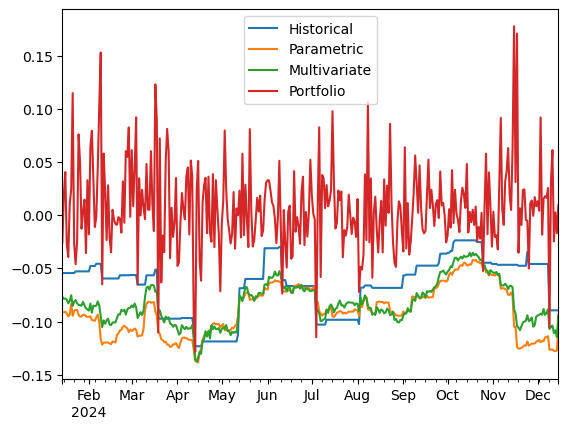

In [120]:
var_data.plot()

<Axes: >

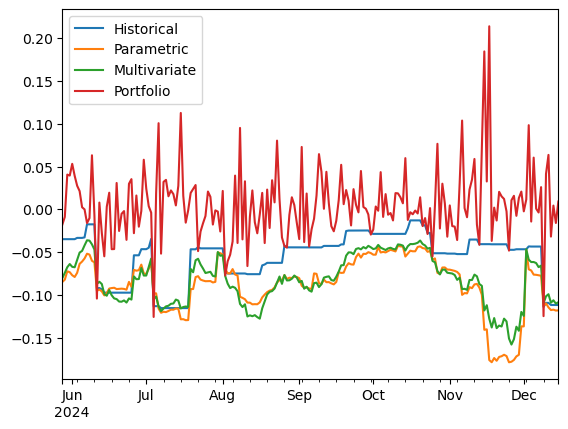

In [121]:
current_var_data.plot()

In [122]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.026706,0.011869,0.011869
Kupiec Stat,4.602656,14.70455,14.70455
P-value,0.031922,0.000126,0.000126


In [123]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064356,0.019802,0.014851
Kupiec Stat,0.80681,4.981952,7.175969
P-value,0.369065,0.025613,0.007389


# Principal Component Analysis

## Historical PCA

In [126]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.7686699 , 0.07392824, 0.05882166, 0.05269731, 0.04588289])

In [127]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014885
ADAUSDT     0.015236
ALGOUSDT    0.017088
APTUSDT     0.016126
ARBUSDT     0.016920
              ...   
WBTCUSDT    0.009266
WLDUSDT     0.021944
XLMUSDT     0.012075
XRPUSDT     0.010577
XTZUSDT     0.016072
Name: PC1, Length: 63, dtype: float64

<Axes: >

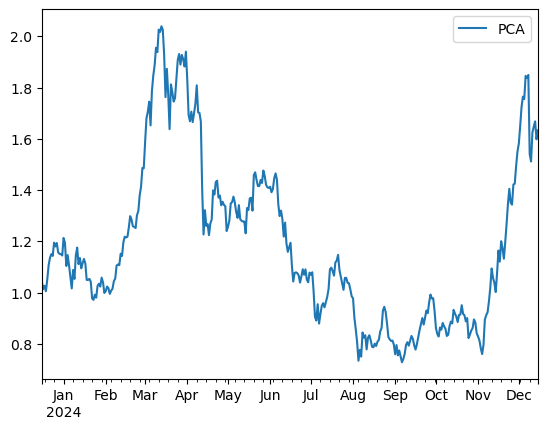

In [128]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

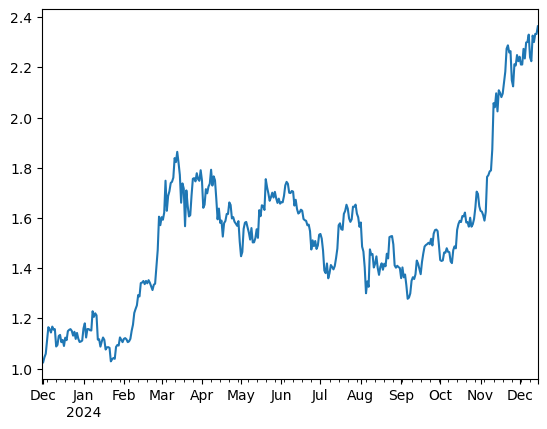

In [129]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [130]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.418643
WBETHUSDT    0.421033
ETHUSDT      0.421128
ATOMUSDT     0.447086
               ...   
FLOKIUSDT    1.128868
BONKUSDT     1.130832
WLDUSDT      1.134111
PEPEUSDT     1.182937
OMUSDT       1.533254
Length: 64, dtype: float64

<Axes: >

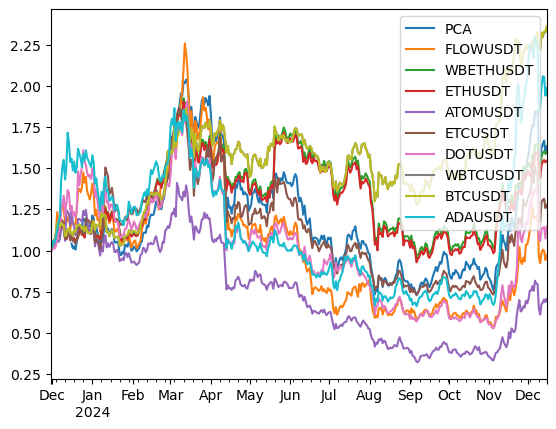

In [131]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

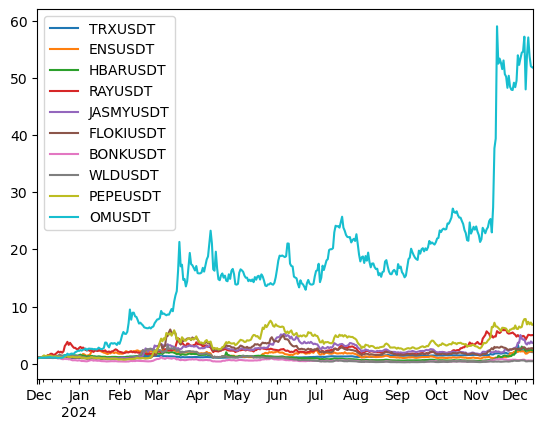

In [132]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [134]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53206572, 0.15393127, 0.13485039, 0.10263018, 0.07652244])

In [135]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.101886
BTCUSDT      0.061487
JASMYUSDT    0.167677
SOLUSDT      0.101090
ETHUSDT      0.082444
TRXUSDT      0.049178
BBUSDT       0.213856
BNBUSDT      0.067687
PEPEUSDT     0.154695
Name: PC1, dtype: float64

<Axes: >

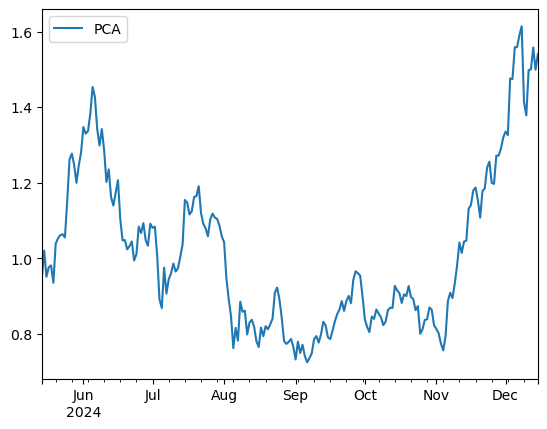

In [136]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

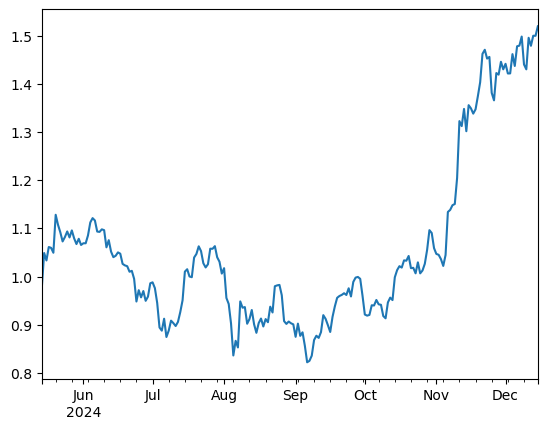

In [137]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [138]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.388879
ETHUSDT      0.408396
BNBUSDT      0.412433
BTCUSDT      0.428127
JASMYUSDT    0.646952
PEPEUSDT     0.712616
BBUSDT       0.726152
TRXUSDT      0.881243
OMUSDT       0.882129
dtype: float64

<Axes: >

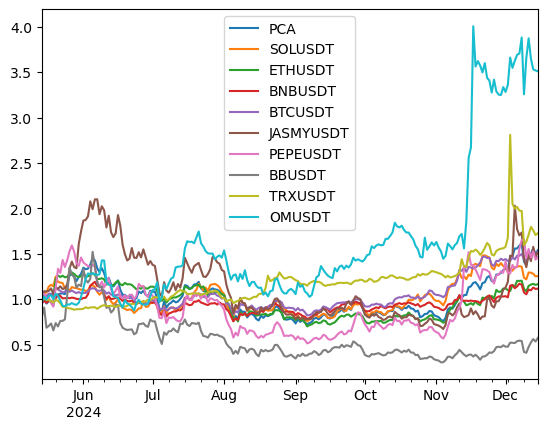

In [139]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [141]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.899564
BBUSDT       1.573088
JASMYUSDT    1.247425
SOLUSDT      1.145441
BTCUSDT      1.000000
ETHUSDT      0.956037
OMUSDT       0.890337
BNBUSDT      0.663814
TRXUSDT      0.264747
Name: BTCUSDT, dtype: float64

In [142]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.692329
PEPEUSDT     1.719590
ETHUSDT      1.483875
OMUSDT       1.192177
BNBUSDT      1.085930
SOLUSDT      1.020114
BTCUSDT      1.000000
JASMYUSDT    0.357830
TRXUSDT     -0.078570
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [144]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [145]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.654900
ETHUSDT,0.407394
BBUSDT,0.285487
BNBUSDT,0.260662
JASMYUSDT,0.119090
OMUSDT,0.066439
TRXUSDT,-0.017377
PEPEUSDT,-0.162394
SOLUSDT,-0.295268


### Regression to PCA

In [147]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.7399796585487455

In [148]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.255767
BNBUSDT      1.111204
PCA          1.000000
ETHUSDT      0.976162
SOLUSDT      0.799804
JASMYUSDT    0.404899
PEPEUSDT     0.368083
BBUSDT       0.349621
OMUSDT       0.232500
TRXUSDT      0.181611
dtype: float64

In [149]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.918149
ETHUSDT      1.262348
SOLUSDT      1.168869
PCA          1.000000
BNBUSDT      0.862198
BBUSDT       0.556943
OMUSDT       0.533183
JASMYUSDT    0.164403
PEPEUSDT     0.120885
TRXUSDT      0.111061
dtype: float64

### Correlation Matrix

<Axes: >

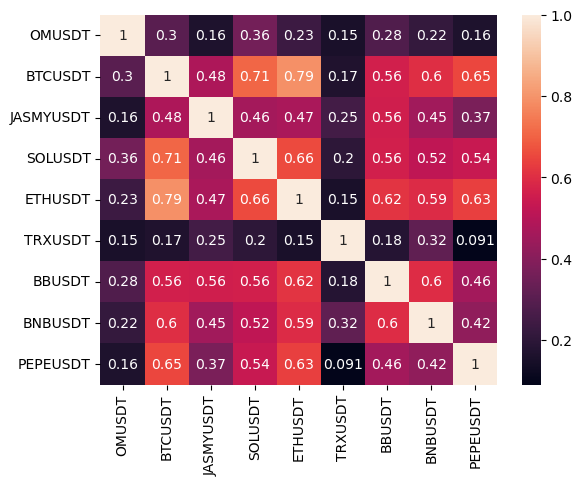

In [151]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

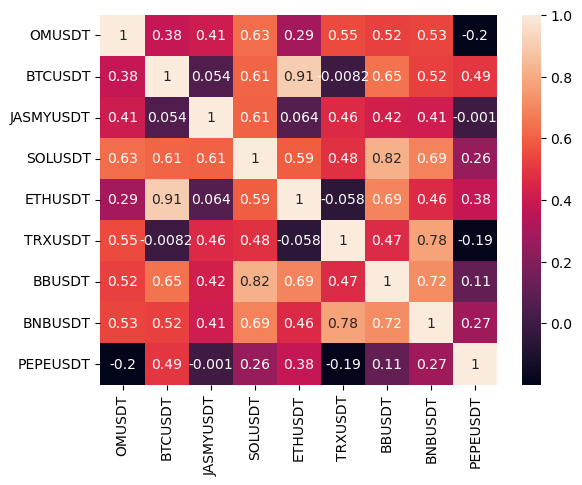

In [152]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [154]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [155]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-09,0.000000,0.000003,0.0,0.000000,0.0,0.013059,0.0,0.0,0.0,0.0,...,0.037621,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-06-08,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-07-08,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.968182,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-08-07,0.443127,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.518687,0.0
2024-09-06,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.550875,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-10-06,0.012169,0.000000,0.0,0.098757,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.311741,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-11-05,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.472310,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-12-05,0.000000,0.077375,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01436,0.171202,0.0
2024-12-15,0.637898,0.056065,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0


In [156]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

AAVEUSDT     0.637898
PEPEUSDT     0.297601
ADAUSDT      0.056065
FDUSDUSDT    0.008436
XLMUSDT      0.000000
               ...   
GALAUSDT     0.000000
GRTUSDT      0.000000
HBARUSDT     0.000000
ICPUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-15 00:00:00, Length: 63, dtype: float64